When you’re processing hundreds or thousands of structured image documents—like tax forms, Energy Performance Certificates (EPCs), or insurance statements etc.—extracting text from every single page can be slow and costly. Often, you don’t need to know what the text says right away; you just need to know whether the layout matches a known template before investing in expensive OCR or NLP pipelines.

By comparing documents purely based on structure and layout, you can quickly filter, categorize, or flag anomalies. This approach is invaluable for any domain where documents follow consistent formats: mortgage applications, legal contracts, invoices, or medical records. In this post, we’ll explore a lightweight method to perform this, letting you decide where to dig deeper—only when it matters.

The following code is available on [github](https://github.com/samsaara/layout-sim). Feel free to clone and run the [notebook](https://github.com/samsaara/layout-sim/blob/main/notebooks/layout-sim.ipynb) to follow.

# Setup

In [ ]:
#| code-fold: true

import matplotlib.pyplot as plt

from PIL import Image
from glob import glob
from pathlib import Path
from doclayout_yolo import YOLOv10
from transformers import AutoModel, AutoProcessor

from src.main import get_features
from src.doclayout import detect, get_mask
from src.metrics_features import get_common_metrics
from src.embeddings import get_hf_cosine_similarity, get_mask_embedding_scores

We use the [DocLayout YOLO](https://github.com/opendatalab/DocLayout-YOLO/) model to aid us in detecting the layout.

In [ ]:
model = YOLOv10("models/doclayout_yolo_docstructbench_imgsz1024.pt")

We'd ideally have a reference image against which we would compare all the incoming sample images. If they're similar, we might perform futher processing. For this use case, I collected a few European EPCs (as part of some interviewing task awhile ago) and I chose one as a reference image. Let's see what it looks like.

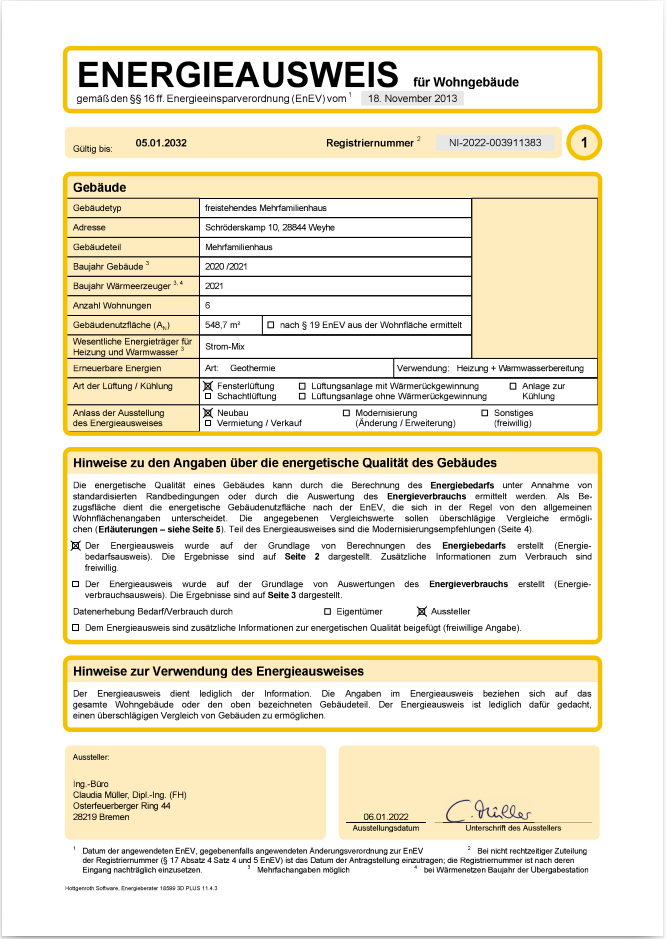

In [5]:
Image.open("data_files/reference.png")

# Detect Layout

Because we can't use text, let's try to detect only the layouts from this reference image...

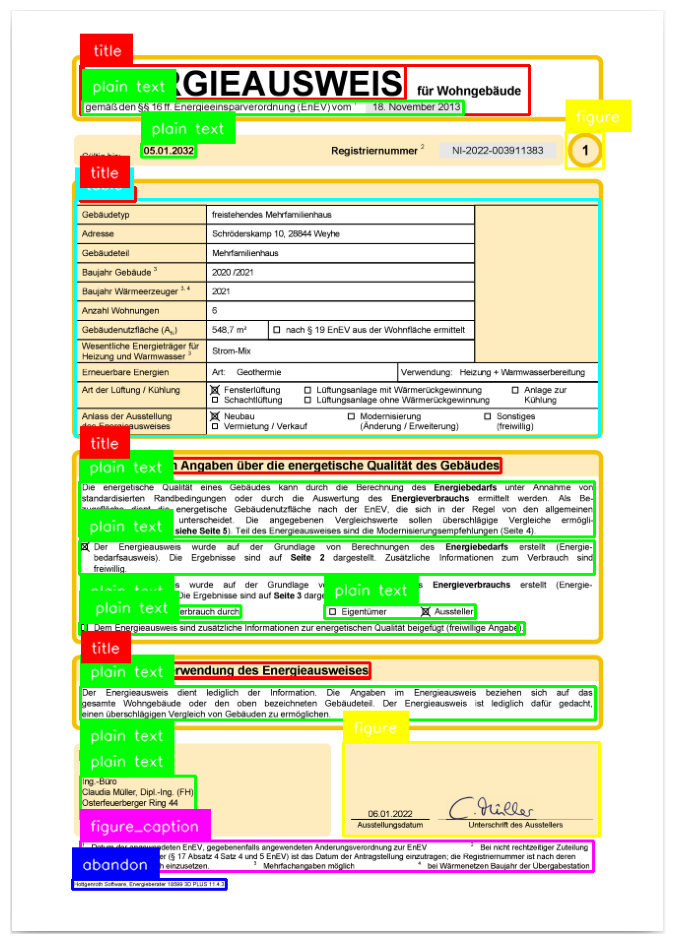

In [6]:
_ = detect(Image.open("data_files/reference.png"), plot=True, labels=True)

Great! We see that it detected almost all of the layouts. This was done on a color image. Let us now see if it sees anything different from a grayscale image.

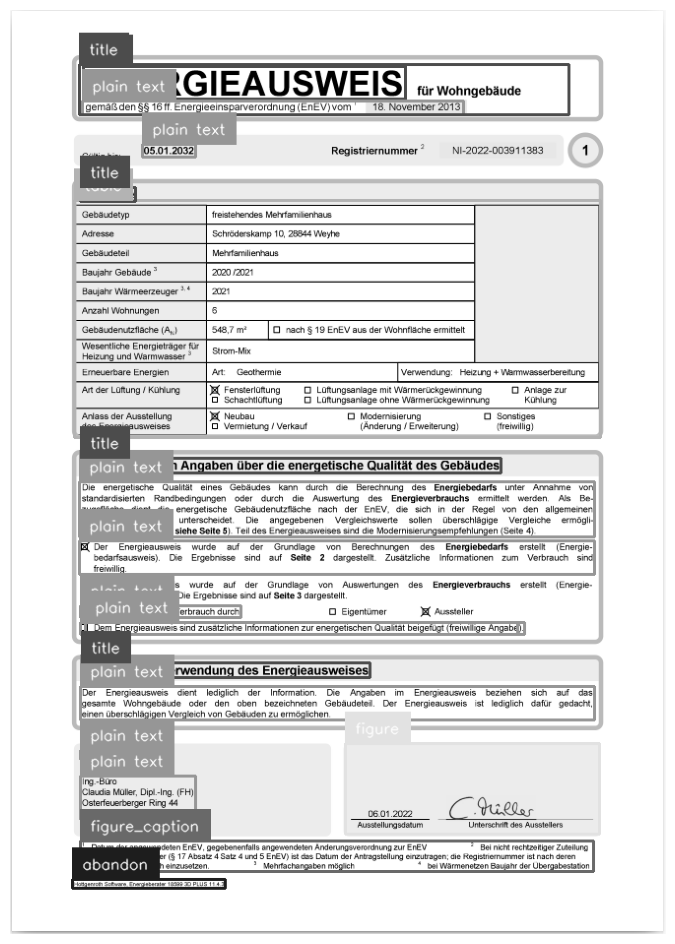

In [7]:
dc = detect(
    Image.open("data_files/reference.png").convert("L"),
    plot=True,
    labels=True,
)

the detections mostly overlap but some are detected only in color version and some only in grayscale.

In [8]:
dc

Detections(xyxy=array([[ 71.123146, 687.8052  , 593.94336 , 721.8409  ],
       [ 70.97421 , 479.21695 , 593.3649  , 535.53595 ],
       [ 71.24948 , 455.39197 , 498.4701  , 470.55954 ],
       [ 70.65032 , 539.8029  , 593.3954  , 573.8178  ],
       [ 72.065994, 663.6691  , 365.0041  , 678.9194  ],
       [ 65.575966, 193.63667 , 599.0595  , 434.21326 ],
       [ 63.092915, 883.88824 , 218.96974 , 892.8909  ],
       [ 71.35639 , 778.1166  , 188.13594 , 822.87744 ],
       [ 71.89993 , 605.70557 , 234.40808 , 617.51855 ],
       [ 71.382614, 622.5114  , 522.1956  , 634.0853  ],
       [340.11487 , 745.31305 , 598.5524  , 837.3176  ],
       [ 74.81994 ,  57.23144 , 401.61005 ,  90.07859 ],
       [ 71.9376  , 844.9032  , 592.02576 , 875.8439  ],
       [ 73.877815,  92.0042  , 460.47784 , 106.27179 ],
       [ 71.9376  , 844.9032  , 592.02576 , 875.8439  ],
       [ 70.16747 ,  55.55576 , 567.40125 , 106.37981 ],
       [ 71.25632 , 752.0478  , 110.301605, 761.9804  ],
       [ 76.372

The detections object returns the bounding boxes in `xyxy` format along with their confidence scores and corresponding labels. We shall use this information to construct a bitmap mask.

# Get bitmap mask

A bitmap mask is a simple stencil that tells a program which parts of an image to pay attention to and which to ignore. It’s useful when you want to focus on layout, highlight specific regions, or filter out irrelevant content, making tasks like document comparison, template matching, or image editing much faster and more efficient.

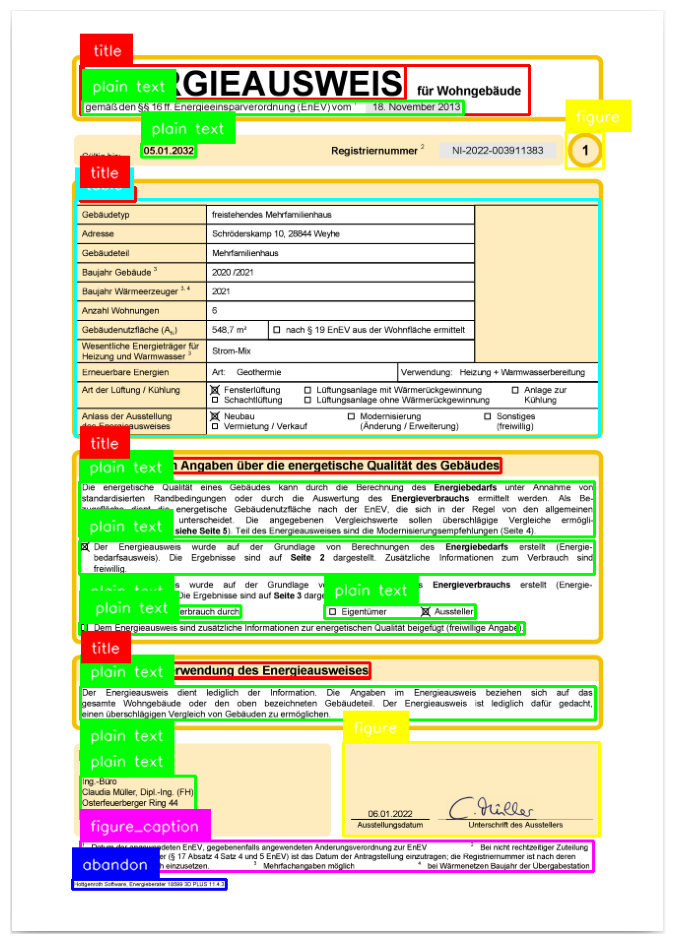

In [9]:
img = Image.open("data_files/reference.png")
dc = detect(img, plot=True, labels=True)

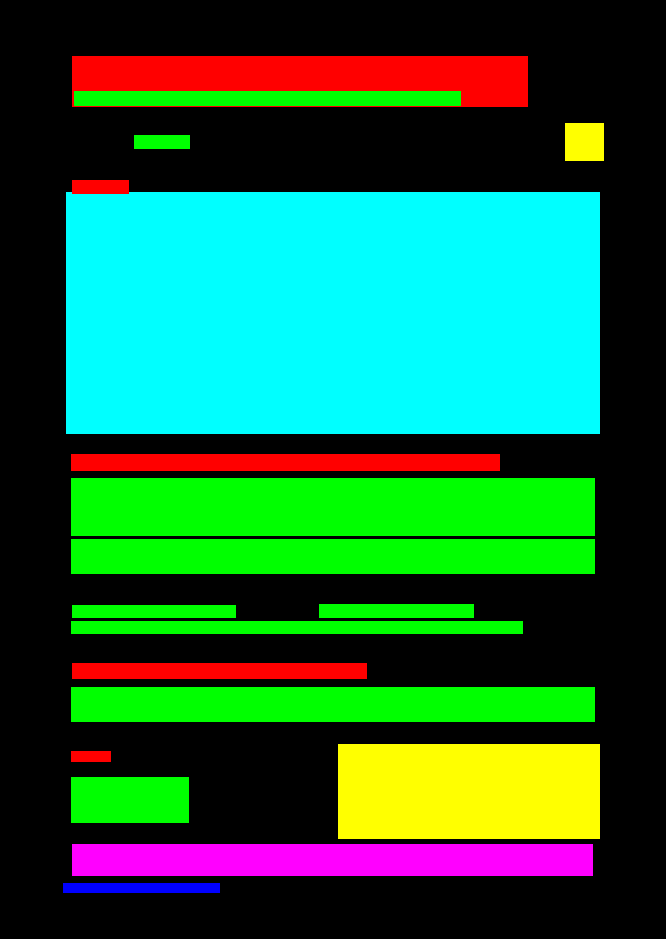

In [10]:
mask = get_mask(*img.size[::-1], dc)
mask

Sweet! Here's what we did in the `get_mask` function:

- assign a matrix of zeros (3 channels)
- get the bounding boxes from the YOLO detections
- convert them into np.array coordinate system (PIL Image's coordinate system is top to bottom)
- compute the area of the box
- fill the area with the color of the corresponding class
  - we compute the areas at once and fill in the order of largest to smallest so that we can find the overlapped small boxes.
 
This way we end up with a colored mask with layout encoded information. Let's derive a mask for another variant.

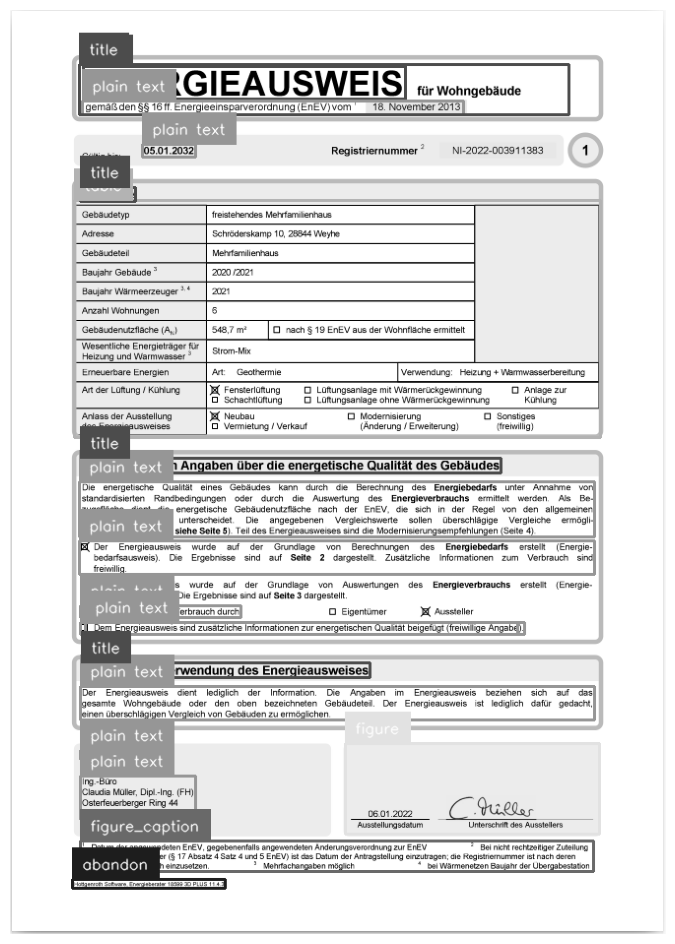

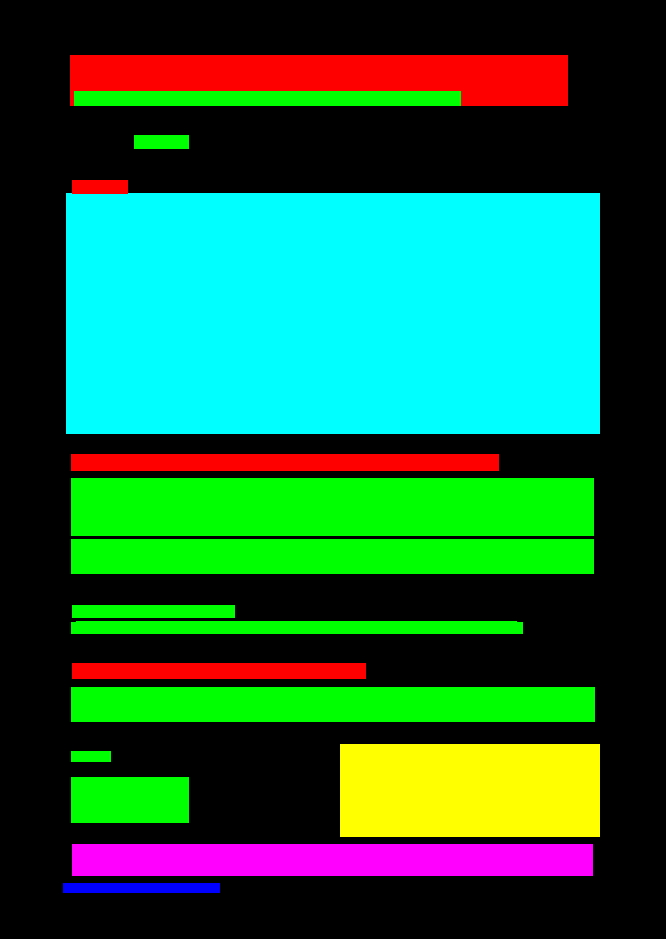

In [11]:
img_L = Image.open("data_files/reference.png").convert("L")
get_mask(*img_L.size[::-1], detect(img_L, labels=True, plot=True))

Now as we noted before, different variations of the image produce slightly different layouts. We shall create a weighted mask by merging these masks by each channel optionally with weights. By default, each mask has same weight.

## Merge Masks

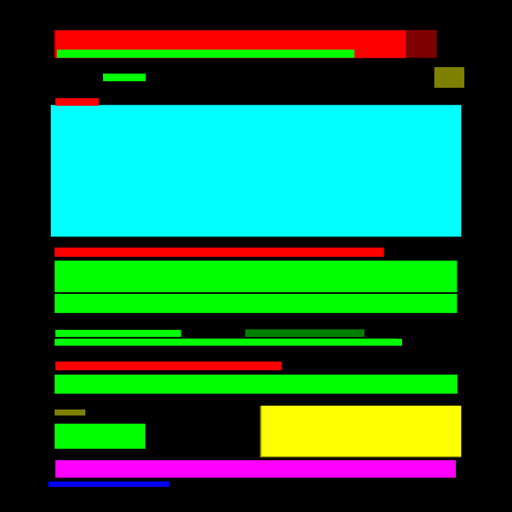

In [13]:
from src.doclayout import get_merged_mask
merged_mask = get_merged_mask("data_files/reference.png")
merged_mask

We merged the colored & grayscale variations of the reference image and standardized its dimensions to 512x512 to compare with other sample images later on. The darker a portion is, the stronger the overlap. Sometimes, the labels would also be different for a given layout detected, resulting in a mixed color in the final merged mask which would allow us to see disagreements between different masks.

# Compute Features

## Embeddings

We now derive image embeddings for these merged masks. By projecting bitmap masks into an embedding space, we turn the visual layout into a compact, numerical representation. This lets you quickly measure similarity between documents or images without expensive pixel-by-pixel comparisons or OCR. Besides, it scales well. ;)

### Image
For this, we use [dino-vits16](https://huggingface.co/facebook/dino-vits16) model.

Here we load a reference image along with a matching and non-matching training images to explore.

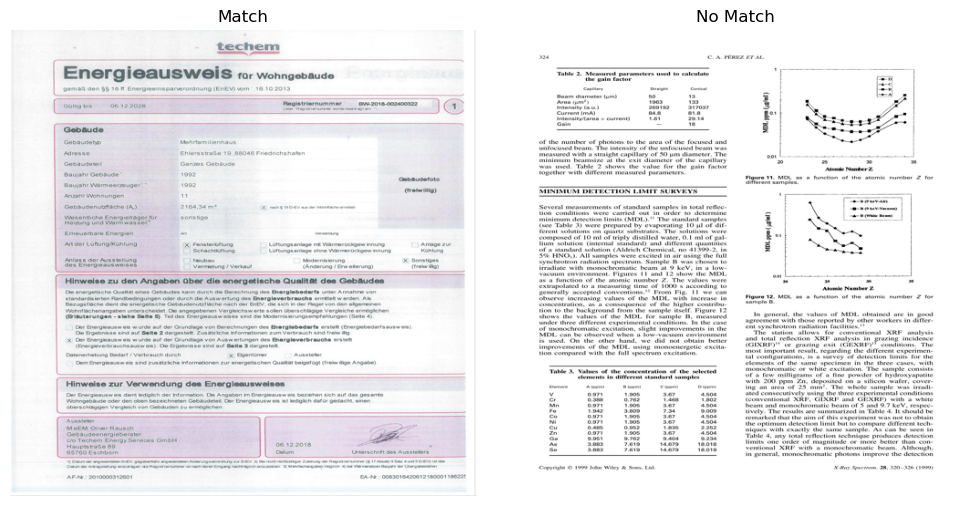

In [15]:
# | code-fold: true

# load the model and processor
# ckpt = "google/siglip2-base-patch16-224"
ckpt = "facebook/dino-vits16"

emb_model = AutoModel.from_pretrained(ckpt).eval()
emb_processor = AutoProcessor.from_pretrained(ckpt, use_fast=True)

mask_ref = get_merged_mask("data_files/reference.png")
mask_samp = get_merged_mask("data_files/train_images/m_0.png")
mask_samp_nomatch = get_merged_mask("data_files//train_images/nm_1.jpg")

img1 = Image.open("data_files/train_images/m_0.png").resize((512, 512))
img2 = Image.open("data_files/train_images/nm_1.jpg").resize((512, 512))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

axes[0].imshow(img1)
axes[0].axis("off")  # hide axes
axes[0].set_title("Match")

axes[1].imshow(img2)
axes[1].axis("off")
axes[1].set_title("No Match")

plt.tight_layout()
plt.show()

In [16]:
get_hf_cosine_similarity(
    emb_model, emb_processor, [mask_ref, mask_samp, mask_samp_nomatch]
)

[0.9231094121932983, 0.8350296020507812]

We see that our reference image is closer to the sample image than to the non-matching sample. That's great news!

Let's compute few other statisical embeddings.

### Manual

In [17]:
mask_emb_scores = get_mask_embedding_scores([mask_ref, *[mask_samp, mask_samp_nomatch]])
mask_emb_scores

defaultdict(list,
            {'cos_sim_hu_moments': [-0.3719817103657597, 0.10362230071894155],
             'cos_sim_zernike': [0.9552975209574077, 0.8994658287209426],
             'cos_sim_fourier': [0.9995830287092948, 0.6172465282448778],
             'cos_sim_regionprops': [0.9999954558167454, 0.9999837891488262],
             'cos_sim_hog': [0.589646804245924, 0.3039637953469709]})

We already see that many metrics above lean towards identifying correct match. Ofc, we need test it on more data before we generalise.

## Distance & Similarity Metrics

We now compute some Intersection and Correlation metrics of pixel distribution histrograms, metrics based on image hashes etc. 

In [18]:
metrics = get_common_metrics(mask_ref, [mask_samp, mask_samp_nomatch])
metrics

defaultdict(list,
            {'metric_avg_hash': [np.int64(13), np.int64(19)],
             'metric_phash': [np.int64(20), np.int64(26)],
             'metric_phash_simple': [np.int64(24), np.int64(20)],
             'metric_dhash': [np.int64(22), np.int64(24)],
             'metric_dhash_vertical': [np.int64(14), np.int64(30)],
             'metric_whash': [np.int64(16), np.int64(12)],
             'metric_crop_resistant_hash': [1.020833333333333,
              0.03348214285714324],
             'metric_ssim': [0.716413475931163, 0.5832392822458005],
             'metric_dice_coeff': [0.741792643470003, 0.7053555824309493],
             'metric_iou': [0.5895631110565024, 0.5448257242366155],
             'metric_hist_sim': [0.9863640115685008, 0.909850095867875]})

# Train & Run a Binary Classifier

## Gather Features

`get_features` computes all the features we've computed so far and wraps them in a dataframe.

In [20]:
features = get_features(mask_ref, [mask_samp, mask_samp_nomatch])
features.head().T

0          1
cos_sim_hf                   0.923109   0.835030
cos_sim_hu_moments          -0.371982   0.103622
cos_sim_zernike              0.955298   0.899466
cos_sim_fourier              0.999583   0.617247
cos_sim_regionprops          0.999995   0.999984
cos_sim_hog                  0.589647   0.303964
metric_avg_hash             13.000000  19.000000
metric_phash                20.000000  26.000000
metric_phash_simple         24.000000  20.000000
metric_dhash                22.000000  24.000000
metric_dhash_vertical       14.000000  30.000000
metric_whash                16.000000  12.000000
metric_crop_resistant_hash   1.020833   0.033482
metric_ssim                  0.716413   0.583239
metric_dice_coeff            0.741793   0.705356
metric_iou                   0.589563   0.544826
metric_hist_sim              0.986364   0.909850

This is now a simple binary classification problem with tabular data. We assign the label `1` if the training image is similar to the reference image, `0` otherwise. We'll skip the training part here in this post for brevity and just take a look at the inference done with gradio. For complete training, feature importances, model explainability, refer to the code in the [repo](https://github.com/samsaara/layout-sim) or its [notebook](https://github.com/samsaara/layout-sim/blob/main/notebooks/layout-sim.ipynb). Checkout the project's [README](https://github.com/samsaara/layout-sim) to know more.

Here's a short demo:

In [5]:
#| code-fold: true

from IPython.display import Video
Video("demo.mp4", embed=True, width=750, height=500)